### _**Послание ревьюеру:** Я исправил тот косяк с гистограмами._

# Вступление
## Данные
Исторические данные о продажах игр показывающее, оценки пользователей и экспертов, жанры и платформы с 1980 по 2016 год
### Описание столбцов:
**Name** — название игры

**Platform** — платформа

**Year_of_Release** — год выпуска

**Genre** — жанр игры

**NA_sales** — продажи в Северной Америке (миллионы долларов)

**EU_sales** — продажи в Европе (миллионы долларов)

**JP_sales** — продажи в Японии (миллионы долларов)

**Other_sales** — продажи в других странах (миллионы долларов)

**Critic_Score** — оценка критиков (от 0 до 100)

**User_Score** — оценка пользователей (от 0 до 10)

**Rating** — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.
## Цель
Выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
from collections import Counter

In [3]:
from scipy.stats import ttest_1samp, ttest_ind
from scipy.stats import levene

# Шаг 2. Откройте файл с данными и изучите общую информацию

In [4]:
df = pd.read_csv('/datasets/games.csv')
df.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


# Шаг 3. Подготовьте данные

## Замените названия столбцов (приведите к нижнему регистру)

In [5]:
df.columns = df.columns.map(lambda x: x.lower())
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


## Преобразуйте данные в нужные типы. Опишите, в каких столбцах заменили тип данных и почему;

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Кандидаты на изменение типа:

year_of_release - все года целочисленны, а float64 жрет дополнительно память

user_score - там находятся строковые значения, которые пока надо обработать.


Пока надо обработать столбцы. Потом привести к нужному типу

## Обработайте пропуски при необходимости

In [7]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

### Работаю с name

In [8]:
print('До выполнения работ:', df['name'].isnull().sum())

До выполнения работ: 2


In [9]:
df = df.dropna(subset=['name']).reset_index(drop=True)
#df.isnull().sum()
print('После выполнения работ:', df['name'].isnull().sum())

После выполнения работ: 0


### Работаю с year_of_release

Я прошерстил датасет и заметил, что игры обычно выходят в один год для разных платформ. Поэтому можно заполнить пропущенные данные в этом столбце просто сопоставив с другими платформами тех же игр

In [10]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [11]:
print('До выполнения работ:', df['year_of_release'].isnull().sum())

До выполнения работ: 269


In [12]:
df.year_of_release = df.groupby('name')['year_of_release'].transform(lambda x:  x.fillna(scipy.stats.mode(x).mode[0]))

In [13]:
print('После выполнения работ:', df['year_of_release'].isnull().sum())

После выполнения работ: 146


Таким путем мы смогли заполнить 123 пропуска в данном столбце.

### Работаю с critic_score

In [14]:
print('До выполнения работ:', df['critic_score'].isnull().sum())

До выполнения работ: 8576


Заполню аналогично предыдущему варианту.

In [15]:
df['critic_score'] = df.groupby('name')['critic_score'].transform(lambda x: x.fillna(x.mean()))

In [16]:
print('После выполнения работ:', df['critic_score'].isnull().sum())

После выполнения работ: 7615


In [17]:
#df = df.dropna(subset = ['critic_score']).reset_index(drop=True)

### Работаю с user_score

У user_score есть значения tbd. Надо их преобразовать

In [18]:
df.loc[df.user_score=='tbd', 'user_score'] = np.nan
df.user_score = df.user_score.astype('float')

In [19]:
print('До выполнения работ:', df['user_score'].isnull().sum())

До выполнения работ: 9123


In [20]:
df['user_score'] = df.groupby('name')['user_score'].transform(lambda x: x.fillna(x.mean()))

In [21]:
print('После выполнения работ:', df['user_score'].isnull().sum())

После выполнения работ: 8024


### Работаю с critic_score - 2

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16567 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       9098 non-null float64
user_score         8689 non-null float64
rating             9949 non-null object
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


Как мы можем видеть из таблицы корреляций ниже, critic_score тесно связан с user_score

In [23]:
df.corr()['critic_score']

year_of_release    0.019328
na_sales           0.231830
eu_sales           0.215075
jp_sales           0.151256
other_sales        0.193422
critic_score       1.000000
user_score         0.548676
Name: critic_score, dtype: float64

#### Задумка: разобьем user_score на когорты, а затем заполним critic_score как среднее у каждой когорты

In [24]:
print('До выполнения работ:', df['critic_score'].isnull().sum())

До выполнения работ: 7615


In [25]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [26]:
# создаю столбец когорт
df['user_score_cat'] = df['user_score'].apply(lambda x: x//1)

In [27]:
# смотрю на среднее каждой когорты
df.groupby('user_score_cat').mean()['critic_score']

user_score_cat
0.0    52.250000
1.0    43.340860
2.0    48.467822
3.0    50.385031
4.0    56.278505
5.0    61.109621
6.0    65.627308
7.0    71.280839
8.0    76.699202
9.0    80.401656
Name: critic_score, dtype: float64

In [28]:
# Я не особо умный, зато трудолюбывый :)
# Заполняю пропуски
df.loc[df['user_score_cat']==0, 'critic_score'] = df.loc[df['user_score_cat']==0, 'critic_score'].fillna(52.250000)
df.loc[df['user_score_cat']==1, 'critic_score'] = df.loc[df['user_score_cat']==1, 'critic_score'].fillna(43.340860)
df.loc[df['user_score_cat']==2, 'critic_score'] = df.loc[df['user_score_cat']==2, 'critic_score'].fillna( 48.46782)
df.loc[df['user_score_cat']==3, 'critic_score'] = df.loc[df['user_score_cat']==3, 'critic_score'].fillna( 50.38503)
df.loc[df['user_score_cat']==4, 'critic_score'] = df.loc[df['user_score_cat']==4, 'critic_score'].fillna(56.278505)
df.loc[df['user_score_cat']==5, 'critic_score'] = df.loc[df['user_score_cat']==5, 'critic_score'].fillna( 61.10962)
df.loc[df['user_score_cat']==6, 'critic_score'] = df.loc[df['user_score_cat']==6, 'critic_score'].fillna( 65.62730)
df.loc[df['user_score_cat']==7, 'critic_score'] = df.loc[df['user_score_cat']==7, 'critic_score'].fillna( 71.28083)
df.loc[df['user_score_cat']==8, 'critic_score'] = df.loc[df['user_score_cat']==8, 'critic_score'].fillna( 76.69920)
df.loc[df['user_score_cat']==9, 'critic_score'] = df.loc[df['user_score_cat']==9, 'critic_score'].fillna(  80.4016)

In [29]:
print('После выполнения работ:', df['critic_score'].isnull().sum())

После выполнения работ: 7279


In [30]:
df.drop('user_score_cat', axis='columns', inplace=True)

### Работаю с rating

In [31]:
print('До выполнения работы')
df.rating.isnull().sum()

До выполнения работы


6764

Заполняю рейтинг модой 

In [32]:
df['rating'] = df.groupby('name')['rating'].transform(lambda x: x.fillna(Counter(x).most_common()[0][0]))

In [33]:
print('После выполнения работы')
df.rating.isnull().sum()

После выполнения работы


6485

## Работаю с user_score - 2

In [34]:
print('До выполнения работ:', df['user_score'].isnull().sum())

До выполнения работ: 8024


In [35]:
df['critic_score_cat'] = df['critic_score']//10

In [36]:
df.groupby('critic_score_cat').mean()['user_score'].apply(lambda x: np.round(x,1))

critic_score_cat
1.0    2.9
2.0    3.6
3.0    4.6
4.0    5.6
5.0    6.3
6.0    6.9
7.0    7.5
8.0    7.8
9.0    8.3
Name: user_score, dtype: float64

In [37]:
df.loc[df['critic_score_cat']==1, 'user_score'] = df.loc[df['critic_score_cat']==1, 'user_score'].fillna(2.9)
df.loc[df['critic_score_cat']==2, 'user_score'] = df.loc[df['critic_score_cat']==2, 'user_score'].fillna(3.6)
df.loc[df['critic_score_cat']==3, 'user_score'] = df.loc[df['critic_score_cat']==3, 'user_score'].fillna(4.6)
df.loc[df['critic_score_cat']==4, 'user_score'] = df.loc[df['critic_score_cat']==4, 'user_score'].fillna(5.6)
df.loc[df['critic_score_cat']==5, 'user_score'] = df.loc[df['critic_score_cat']==5, 'user_score'].fillna(6.3)
df.loc[df['critic_score_cat']==6, 'user_score'] = df.loc[df['critic_score_cat']==6, 'user_score'].fillna(6.9)
df.loc[df['critic_score_cat']==7, 'user_score'] = df.loc[df['critic_score_cat']==7, 'user_score'].fillna(7.5)
df.loc[df['critic_score_cat']==8, 'user_score'] = df.loc[df['critic_score_cat']==8, 'user_score'].fillna(7.8)
df.loc[df['critic_score_cat']==9, 'user_score'] = df.loc[df['critic_score_cat']==9, 'user_score'].fillna(8.3)

In [38]:
print('После выполнения работ:', df['user_score'].isnull().sum())

После выполнения работ: 7279


In [39]:
df = df.drop('critic_score_cat', axis='columns')

## Работаю с rating - 2

In [40]:
print('До выполнения работ:', df['rating'].isnull().sum())

До выполнения работ: 6485


Поскольку зависимости рейтинга от жанра нет, то у меня остается наиболее очевидный вариант для заполнения пропусков. Заполнить из значением "Нет рейтинга"

In [41]:
df.rating.fillna('No rating', inplace=True)

In [42]:
print('После выполнения работ:', df['rating'].isnull().sum())

После выполнения работ: 0


## Работаю с year_of_release - 2

In [43]:
print('До выполнения работ:', df['year_of_release'].isnull().sum())

До выполнения работ: 146


Здесь я решил заполнить данные исходя из идеи того, что игра для PS4 вряд-ли бы выпускалась в 2005 году.

In [44]:
df['year_of_release'] =  df.groupby('platform')['year_of_release'].transform(lambda x: x.fillna(np.mean(x)))

In [45]:
print('После выполнения работ:', df['year_of_release'].isnull().sum())

После выполнения работ: 0


In [46]:
df.year_of_release = df.year_of_release.astype('int')

## --Итог

In [47]:
print('ИТОГО')
print('Количество пропущенных значений\n',df.isnull().sum(), sep='')
print('----')
print('Форма датасета',df.shape)
print('----')
df.info()

ИТОГО
Количество пропущенных значений
name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       7279
user_score         7279
rating                0
dtype: int64
----
Форма датасета (16713, 11)
----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       9434 non-null float64
user_score         9434 non-null float64
rating             16713 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


## Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.

In [48]:
df['world_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

# Шаг 4. Проведите исследовательский анализ данных

## Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [49]:
df.year_of_release.value_counts()

2008    1492
2009    1442
2010    1281
2007    1202
2011    1153
2006    1019
2005     948
2002     845
2003     803
2004     785
2012     662
2015     606
2014     582
2013     553
2016     502
2001     486
1998     387
2000     351
1999     339
1997     289
1996     263
1995     220
1994     122
1993      60
1982      52
1981      46
1992      43
1991      41
1986      21
1989      17
1983      17
1987      16
1990      16
1988      15
1984      14
1985      14
1980       9
Name: year_of_release, dtype: int64

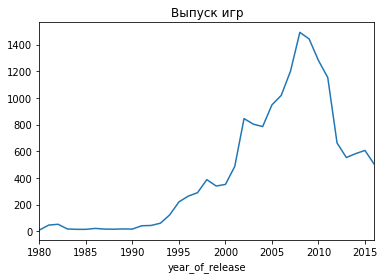

In [50]:
df.groupby('year_of_release')['name'].count().plot(title='Выпуск игр')

Обратите внимание на спад выпуска игр перед 2010 годом.

Я искал насчет этого информацию в Яндексе и пришел к выводу, что на это также оказал влияние кризис 2008 года.

Допустим в октябре 2008 года цена акций EA упала на 75% с 50 до 15 долларов и оставалось на этом уровне ещё пять лет. А ведь EA была самым крупным издателем в мире. Акции Activision Blizzard, Take-Two, THQ, Gamestop и Nintendo провалились на 50%.

## Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. Найдите популярные в прошлом платформы, у которых сейчас продажи на нуле. За какой характерный период появляются новые и исчезают старые платформы?

Суммарные продажи у каждой платформы

In [51]:
df.groupby('platform').sum()['world_sales']

platform
2600      96.98
3DO        0.10
3DS      259.00
DC        15.95
DS       806.12
GB       255.46
GBA      317.85
GC       198.93
GEN       28.35
GG         0.04
N64      218.68
NES      251.05
NG         1.44
PC       259.52
PCFX       0.03
PS       730.86
PS2     1255.77
PS3      939.65
PS4      314.14
PSP      294.05
PSV       54.07
SAT       33.59
SCD        1.86
SNES     200.04
TG16       0.16
WS         1.42
Wii      907.51
WiiU      82.19
X360     971.42
XB       257.74
XOne     159.32
Name: world_sales, dtype: float64

Вот такой график продаж у 10 самых популярных платформ

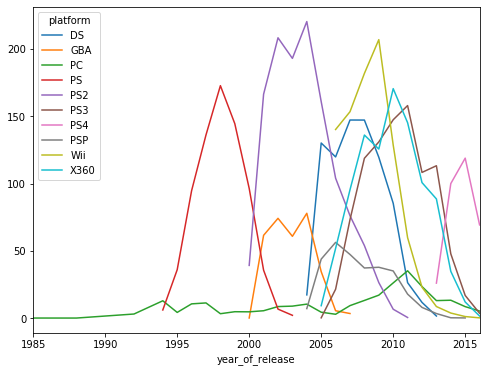

In [52]:
most_popular = df.groupby('platform').sum()['world_sales'].sort_values(ascending=False).index.values[:10]

popular_df = df[df.platform.isin(most_popular)]
popular_df = popular_df.pivot_table(index='year_of_release', columns='platform', values='world_sales', aggfunc='sum')
popular_df.plot(figsize=(8,6))

**Найдите популярные в прошлом платформы, у которых сейчас продажи на нуле**

Судя по графику выше это:

PS2

PS

Wii

X360

PS3

DS

XB

In [53]:
temp = popular_df.T.fillna(0).reset_index()
temp[temp[2016]==0]

year_of_release,platform,1985,1988,1992,1994,1995,1996,1997,1998,1999,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,DS,0.02,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,147.23,147.20,119.56,85.35,26.33,11.67,1.54,0.00,0.00,0.0
1,GBA,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,3.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
3,PS,0.00,0.0,0.0,6.03,35.96,94.7,136.17,172.77,144.53,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
4,PS2,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,76.10,53.90,26.40,6.59,0.45,0.00,0.00,0.00,0.00,0.0
7,PSP,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,47.30,37.24,37.78,35.04,17.82,7.95,3.38,0.24,0.12,0.0


**А теперь делаю окончательный вывод. Платформы с нулевым продажами в 2016 году это:**
* DS
* GBA
* PS
* PS2
* PSP

**Судя по верхнему графику в среднем продолжительность жизни каждой платформы составляет 10 лет**
Хотя лично моё мнение в том, что PC будут еще долго в обороте.

Ниже я решил провести более точные расчеты, а не опираться на данные графика

In [54]:
temp.set_index('platform',inplace=True)

Здесь я подсчитал количество годов с ненулевыми продажами для каждой популярной платформы. Из данного списка стоит исключить PC, так как он явно является выбросом.

In [55]:
life_of_platform = temp[temp!=0].count(axis=1)

In [56]:
print('Среднее время жизни платформы:',life_of_platform.drop('PC').mean())

Среднее время жизни платформы: 10.222222222222221


## Определите, данные за какой период нужно взять, чтобы исключить значимое искажение распределения по платформам в 2016 году.

*Не понял вопроса :(*

*Почему должно быть искажение в 2016 году ?*

*Я так понял вы имеете ввиду сильно смещение среднего арифметического из-за того, что до 1996 года продажи были мизерными*

In [57]:
df.groupby('year_of_release').sum().world_sales

year_of_release
1980     11.38
1981     35.68
1982     36.85
1983     16.80
1984     50.35
1985     53.95
1986     37.08
1987     21.70
1988     47.21
1989     73.45
1990     49.37
1991     32.23
1992     76.16
1993     45.99
1994     81.76
1995     89.15
1996    199.15
1997    201.07
1998    259.79
1999    251.25
2000    201.68
2001    333.30
2002    401.42
2003    372.37
2004    428.17
2005    460.21
2006    523.40
2007    606.16
2008    688.42
2009    664.32
2010    600.07
2011    510.59
2012    360.52
2013    362.58
2014    331.79
2015    267.98
2016    129.94
Name: world_sales, dtype: float64

## Далее работайте только с данными, которые вы определили. Не учитывайте данные за предыдущие годы.

In [58]:
# обрубаю наш датасет. Теперь в новом датафрейме будут данные начиная с 2008 года
df_striped = df[(df['year_of_release']>=2008)].copy()

## Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

Ниже мы можем видеть тот же самый график, который был наверху, но здесь я сделал срез начиная от 2008 года

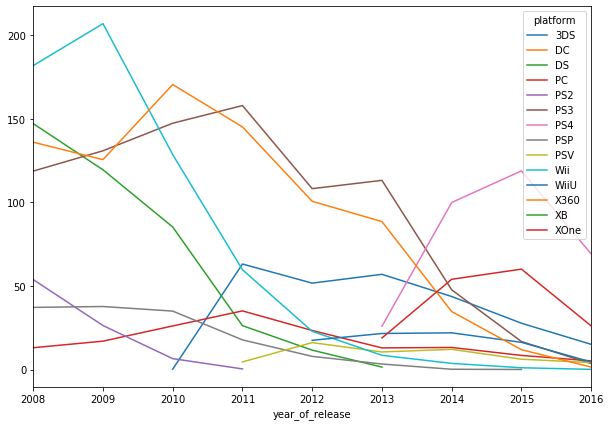

In [59]:
df_striped.pivot_table(index='platform',
                                                               columns='year_of_release',
                                                               values='world_sales',
                                                               aggfunc='sum').T.plot(figsize=(10,7))

Перспективной платформой можно выделить:
* PS4
* PC
* XOne
* WiiU

Несмотря на то, что у ПК не особо большие продажи она демонстрирует стабильность 

Судя по графику можно видеть отрицательный тренд почти на всем рынке видеоигр.

К 2016 году упал продажи у некогда очень продаваемых платформ:
* PS3
* X360
* Wii
* PC изначально не демонстрировал больших продаж, но все равно заметно снижение

## Постройте график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах? Опишите результат.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


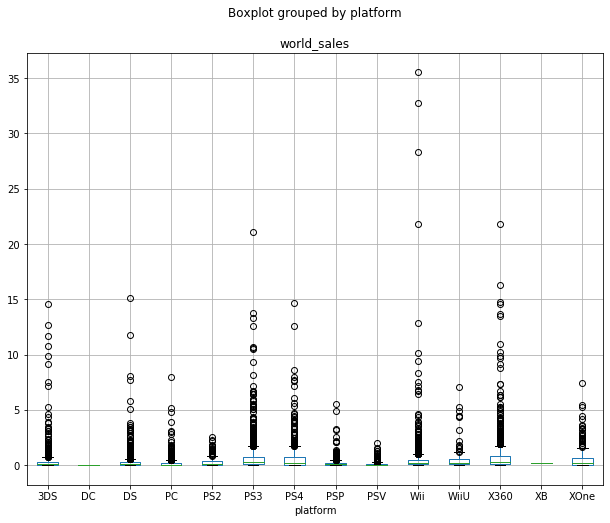

In [60]:
df_striped.boxplot(by='platform', column='world_sales', figsize=(10,8))

^

^

Разница в  основном незначительна. С 1 по 3 квартиль разные платформы демонстрируют похожие продажи. То есть медианные продажи не будут сильно различаться, чего не скажешь о средних. На боксплотах наверху можно наблюдать какой серьезный выброс есть у Wii. Это игра Wii Sports, которая далеко обогнала все остальные игры

## Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы и соотнесите их с продажами игр на других платформах.

In [61]:
df_popular = df_striped[df_striped.platform.isin(most_popular)]

In [62]:
df_popular.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,world_sales
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
14,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,61.0,6.3,E,21.82
15,Wii Fit Plus,Wii,2009,Sports,9.01,8.49,2.53,1.77,80.0,7.4,E,21.80


In [63]:
df_popular_grouped = df_popular.groupby('platform').sum()
df_popular_grouped

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,world_sales
platform,,,,,,,,
DS,2875101,200.56,86.60,76.67,27.82,30117.855830,3223.295000,391.65
PC,1361652,42.24,94.21,0.00,18.54,40199.968568,3647.206667,154.99
PS2,668859,33.38,14.60,8.47,30.89,10074.903227,1057.480000,87.34
PS3,2437600,352.49,296.19,74.88,121.27,60616.537253,5809.544444,844.83
PS4,789937,108.74,141.09,15.96,48.35,21193.749192,1987.225000,314.14
PSP,1555930,34.95,27.08,61.36,16.18,15680.080266,1607.623333,139.57
Wii,2180211,340.73,173.49,48.06,51.63,35647.249362,3733.541667,613.91
X360,2058918,496.50,237.19,9.42,71.89,56362.869228,5431.466667,815.00


In [64]:
popular_platforms_list = df_popular_grouped.index.values
popular_platforms_list

array(['DS', 'PC', 'PS2', 'PS3', 'PS4', 'PSP', 'Wii', 'X360'],
      dtype=object)

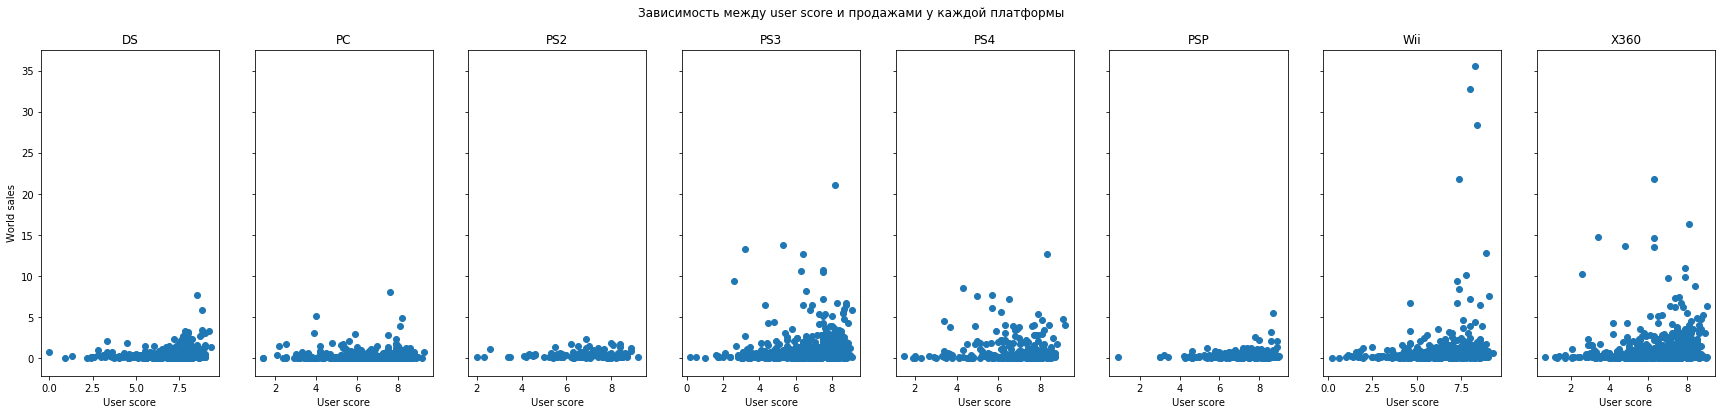

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=8, sharey=True, figsize=(30,6))

ax[0].scatter(data=df_popular[df_popular.platform=='DS'], x='user_score',y='world_sales')
ax[1].scatter(data=df_popular[df_popular.platform=='PC'], x='user_score',y='world_sales')
ax[2].scatter(data=df_popular[df_popular.platform=='PS2'], x='user_score',y='world_sales')
ax[3].scatter(data=df_popular[df_popular.platform=='PS3'], x='user_score',y='world_sales')
ax[4].scatter(data=df_popular[df_popular.platform=='PS4'], x='user_score',y='world_sales')
ax[5].scatter(data=df_popular[df_popular.platform=='PSP'], x='user_score',y='world_sales')
ax[6].scatter(data=df_popular[df_popular.platform=='Wii'], x='user_score',y='world_sales')
ax[7].scatter(data=df_popular[df_popular.platform=='X360'], x='user_score',y='world_sales')

fig.suptitle('Зависимость между user score и продажами у каждой платформы')
ax[0].set_ylabel('World sales')
for i,e in enumerate(ax[:]):
    e.set_xlabel('User score')
    platform_name = popular_platforms_list[i]
    e.set_title(platform_name)
    
    


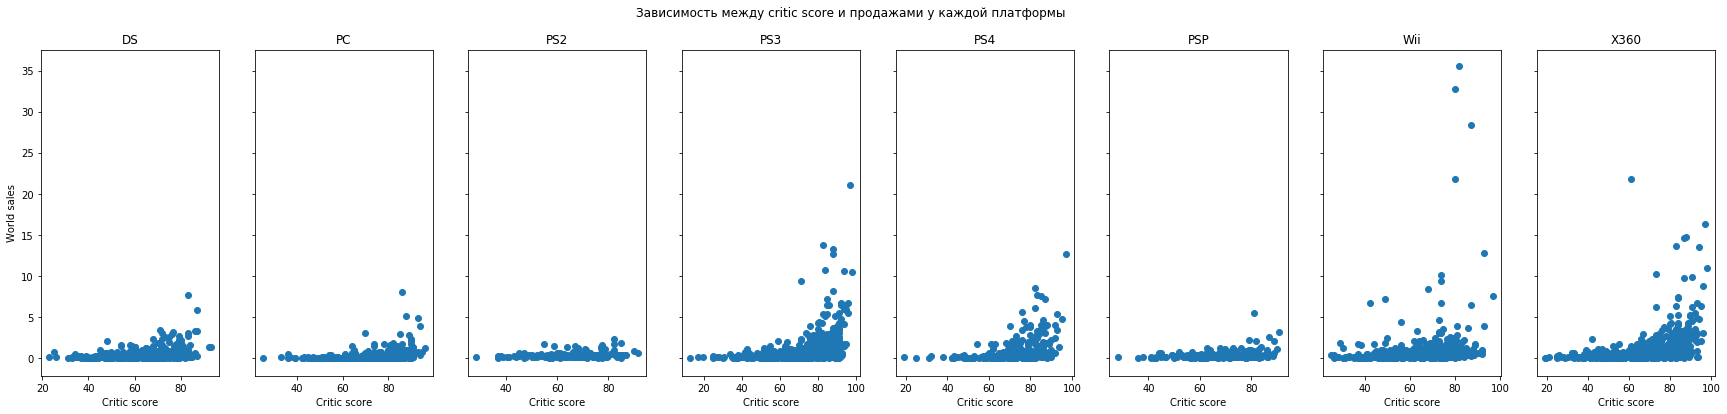

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=8, sharey=True, figsize=(30,6))

ax[0].scatter(data=df_popular[df_popular.platform=='DS'], x='critic_score',y='world_sales')
ax[1].scatter(data=df_popular[df_popular.platform=='PC'], x='critic_score',y='world_sales')
ax[2].scatter(data=df_popular[df_popular.platform=='PS2'],x='critic_score',y='world_sales')
ax[3].scatter(data=df_popular[df_popular.platform=='PS3'],x='critic_score',y='world_sales')
ax[4].scatter(data=df_popular[df_popular.platform=='PS4'],x='critic_score',y='world_sales')
ax[5].scatter(data=df_popular[df_popular.platform=='PSP'],x='critic_score',y='world_sales')
ax[6].scatter(data=df_popular[df_popular.platform=='Wii'],x='critic_score',y='world_sales')
ax[7].scatter(data=df_popular[df_popular.platform=='X360'],x='critic_score',y='world_sales')

fig.suptitle('Зависимость между critic score и продажами у каждой платформы')
ax[0].set_ylabel('World sales')
for i,e in enumerate(ax[:]):
    e.set_xlabel('Critic score')
    platform_name = popular_platforms_list[i]
    e.set_title(platform_name)
    
    
    


Для большинства платформ  заметна положительная корреляция между critic_score/user_score и суммарным количеством продаж

Примечателен тот факт, что для PS2 почти не заметна корреляция судя по графику.

Высокий рейтинг далеко не всегда означает большие продажи, но вот низкий рейтинг почти всегда сулит низкий уровень продаж

In [67]:
print('Кореляции меду critic_score и world_sales\n')
for platform in popular_platforms_list:
    print(f'Платформа: {platform}, Уровень кореляции:',df_popular[df_popular['platform']==platform].corr().loc['critic_score', 'world_sales'])

Кореляции меду critic_score и world_sales

Платформа: DS, Уровень кореляции: 0.29501067868959896
Платформа: PC, Уровень кореляции: 0.28882200865571855
Платформа: PS2, Уровень кореляции: 0.2838157200264882
Платформа: PS3, Уровень кореляции: 0.40773541650128875
Платформа: PS4, Уровень кореляции: 0.39356276649925565
Платформа: PSP, Уровень кореляции: 0.2817564815007379
Платформа: Wii, Уровень кореляции: 0.2073663755448791
Платформа: X360, Уровень кореляции: 0.37518617966070666


In [68]:
print('Кореляции меду user_score и world_sales\n')
for platform in popular_platforms_list:
    print(f'Платформа: {platform}, Уровень кореляции:',df_popular[df_popular['platform']==platform].corr().loc['user_score', 'world_sales'])

Кореляции меду user_score и world_sales

Платформа: DS, Уровень кореляции: 0.22818601187616638
Платформа: PC, Уровень кореляции: -0.022422037902582372
Платформа: PS2, Уровень кореляции: 0.0922329968276797
Платформа: PS3, Уровень кореляции: 0.11562984945446686
Платформа: PS4, Уровень кореляции: -0.02182629905111597
Платформа: PSP, Уровень кореляции: 0.20700370409275612
Платформа: Wii, Уровень кореляции: 0.1377500818545846
Платформа: X360, Уровень кореляции: 0.10343671208461648


Низкие уровни кореляции могут быть обусловлены тем, что кореляции отображает силу линейной взаимосвязи, а у этих данных может быть другая зависимость

## Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


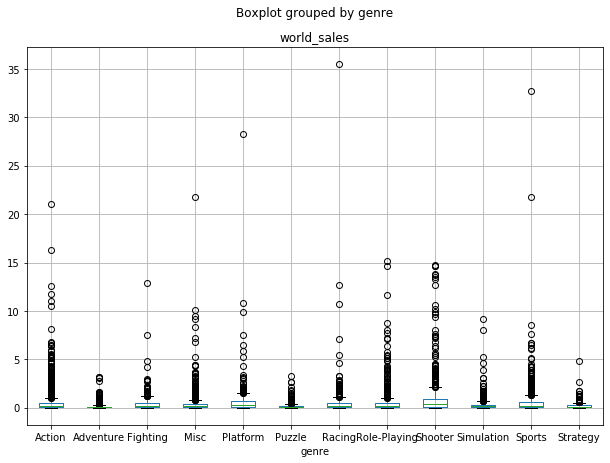

In [69]:
df_striped.boxplot(by='genre', column='world_sales', figsize=(10,7))

Если считать медианы, то наиоблее прибыльными жанрами являются платформеры, шутеры и спорт

Однако некоторые жанры имеют приблизительно одинаковые медианные продажи

In [70]:
df_striped.groupby('genre').median()['world_sales'].sort_values(ascending=False)

genre
Shooter         0.33
Platform        0.24
Sports          0.20
Fighting        0.18
Racing          0.17
Action          0.16
Role-Playing    0.15
Misc            0.14
Simulation      0.12
Puzzle          0.09
Strategy        0.08
Adventure       0.04
Name: world_sales, dtype: float64

А вот здесь вы можете видеть разницу между медианным распределением и средним

In [71]:
df_striped.groupby('genre').mean()['world_sales'].sort_values(ascending=False)

genre
Shooter         1.027664
Platform        0.791336
Sports          0.580000
Racing          0.553786
Role-Playing    0.532989
Fighting        0.478360
Action          0.476243
Misc            0.398762
Simulation      0.321839
Puzzle          0.215709
Strategy        0.209692
Adventure       0.121394
Name: world_sales, dtype: float64

# Шаг 5. Составьте портрет пользователя каждого региона

## Определите для пользователя каждого региона (NA, EU, JP):

### Самые популярные платформы (топ-5). Опишите различия в долях продаж.

#### - NA

Самые популярные платформы у американцев

In [72]:
na_popular_platforms = df_striped.groupby('platform').na_sales.mean().sort_values(ascending=False)[:5]
na_popular_platforms

platform
X360    0.484863
XOne    0.377004
Wii     0.314037
PS3     0.290833
PS4     0.277398
Name: na_sales, dtype: float64

#### - EU

Самые популярные платформы у европейцев

In [73]:
eu_popular_platforms = df_striped.groupby('platform').eu_sales.mean().sort_values(ascending=False)[:5]
eu_popular_platforms 

platform
PS4     0.359923
PS3     0.244381
X360    0.231631
XOne    0.208866
WiiU    0.170952
Name: eu_sales, dtype: float64

#### - JP

Самые популярные платформы у японцев

In [74]:
jp_popular_platforms = df_striped.groupby('platform').jp_sales.mean().sort_values(ascending=False)[:5]
jp_popular_platforms

platform
3DS     0.193931
WiiU    0.088503
PSP     0.079276
PS3     0.061782
DS      0.053578
Name: jp_sales, dtype: float64

In [75]:
data_to_plot = pd.DataFrame(data=[na_popular_platforms,eu_popular_platforms, jp_popular_platforms]).T
data_to_plot

,na_sales,eu_sales,jp_sales
X360,0.484863,0.231631,NaN
XOne,0.377004,0.208866,NaN
Wii,0.314037,NaN,NaN
PS3,0.290833,0.244381,0.061782
PS4,0.277398,0.359923,NaN
WiiU,NaN,0.170952,0.088503
3DS,NaN,NaN,0.193931
PSP,NaN,NaN,0.079276
DS,NaN,NaN,0.053578


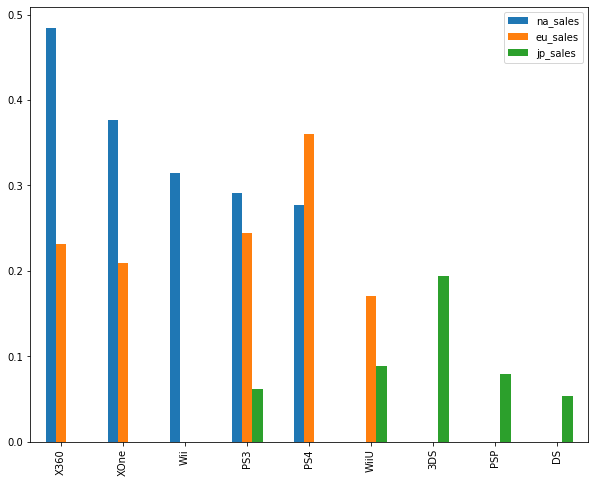

In [76]:
data_to_plot.plot(kind='bar',figsize=(10,8))

#### Вывод:
Азиатский рынок наиоблее обособлен от остальных.

Европейский и американский во многом схожи.

Судя по графику платформа Wii была нацелена именно на американский рынок, учитывая то, что на других рынках она оказалась в аутсайдерах.

- Самой популярной линейкой-платформ в США является - XBox

- Самой популярной линейкой-платформ в Европе является - Playstation

- Самой популярной линейкой-платформ в Японии является - DS(Nintendo)

А в платформе XBOX азиатские геймеры видимо вообще не заинтересованы

### Самые популярные жанры (топ-5). Поясните разницу.

#### - NA

Самые популярные жанры у американцев

In [77]:
na_popular_genres = df_striped.groupby('genre').na_sales.mean().sort_values(ascending=False)[:5]
na_popular_genres

genre
Shooter     0.525563
Platform    0.374130
Sports      0.286053
Fighting    0.240482
Racing      0.230388
Name: na_sales, dtype: float64

#### - EU

Самые популярные жанры у европейцев

In [78]:
eu_popular_genres = df_striped.groupby('genre').eu_sales.mean().sort_values(ascending=False)[:5]
eu_popular_genres 

genre
Shooter     0.352437
Platform    0.243725
Racing      0.224417
Sports      0.191470
Action      0.156411
Name: eu_sales, dtype: float64

#### - JP

Самые популярные жанры у японцев

In [79]:
jp_popular_genres = df_striped.groupby('genre').jp_sales.mean().sort_values(ascending=False)[:5]
jp_popular_genres

genre
Role-Playing    0.174754
Platform        0.093158
Fighting        0.074148
Action          0.045027
Simulation      0.038203
Name: jp_sales, dtype: float64

#### Вывод:
Американский и европейский рынки опять-таки довольно похожи

На азиатском рынке с отрывом лидирует жанр ролевых игр, после которого идет популярный везде жанр платформеров

**В США фаворит:**
- Шутеры

**В США не любят:**
- Action
- Ролевые игры
- Симуляторы

**В Европе фаворит:**
- Шутеры

**В Европе не любят:**
- Файтинги
- Ролевые игры
- Симуляторы

**В Японии фаворит:**
- Ролевухи

**В Японии не любят:**
- Шутеры
- Спортивные игры
- Гонки



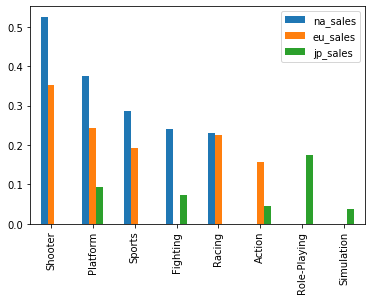

In [80]:
data_to_plot = pd.DataFrame(data=[na_popular_genres,eu_popular_genres, jp_popular_genres]).T
data_to_plot.plot(kind='bar')

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

#### - NA
Популярность рейтингов у американцев

In [81]:
na_popular_ratings = df.groupby('rating').sum().na_sales
na_popular_ratings 

rating
AO              1.26
E            1316.55
E10+          362.04
EC              2.04
K-A             2.59
M             760.71
No rating    1181.79
RP              0.00
T             773.59
Name: na_sales, dtype: float64

#### - EU

Популярность рейтингов у европейцев

In [82]:
eu_popular_ratings =  df.groupby('rating').sum().eu_sales
eu_popular_ratings

rating
AO             0.61
E            719.99
E10+         193.54
EC             0.11
K-A            0.29
M            493.76
No rating    580.01
RP             0.08
T            435.75
Name: eu_sales, dtype: float64

#### - JP

Популярность рейтингов у азиатов

In [83]:
jp_popular_ratings = df.groupby('rating').sum().jp_sales
jp_popular_ratings

rating
AO             0.00
E            201.77
E10+          41.04
EC             0.00
K-A            1.49
M             65.43
No rating    832.15
RP             0.00
T            155.46
Name: jp_sales, dtype: float64

#### Вывод:
На всёх 3 рынках доминируют игры с рейтингом E.

Очень много данных у нас с неразмеченными рейтингами, что намного усложняет анализ продаж

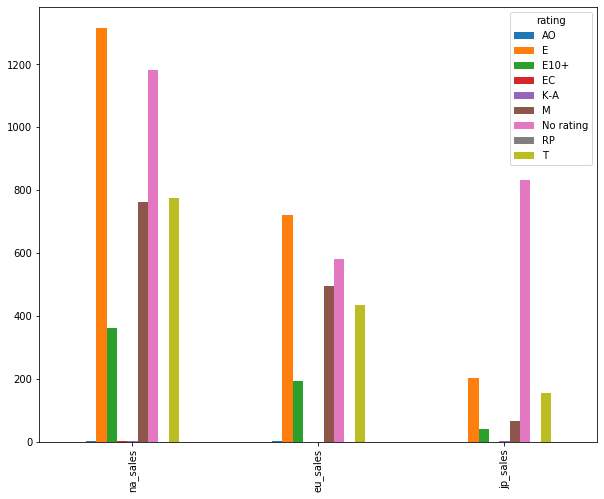

In [84]:
data_to_plot = pd.DataFrame([na_popular_ratings, eu_popular_ratings, jp_popular_ratings])
data_to_plot.plot(kind='bar', figsize=(10,8))

# Шаг 6. Проведите исследование статистических показателей


## Как изменяется пользовательский рейтинг и рейтинг критиков в различных жанрах? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения

### Пользовательский рейтинг

**Медианный пользовательский рейтинг у каждого жанра**

Сначала для графика я хотел взять сумму рейтинга у каждого жанра, но из-за огромного различия в количестве наблюдений каждого жанра я взял медиану

In [85]:
df_striped.groupby('genre').median().user_score

genre
Action          7.1
Adventure       7.1
Fighting        7.4
Misc            6.9
Platform        7.0
Puzzle          7.3
Racing          6.8
Role-Playing    7.6
Shooter         6.9
Simulation      6.9
Sports          6.5
Strategy        7.1
Name: user_score, dtype: float64

In [86]:
df_striped.groupby('genre').std().user_score

genre
Action          1.318739
Adventure       1.631990
Fighting        1.327511
Misc            1.504203
Platform        1.559021
Puzzle          1.355184
Racing          1.551470
Role-Playing    1.123018
Shooter         1.555899
Simulation      1.628011
Sports          1.639869
Strategy        1.543244
Name: user_score, dtype: float64

In [87]:
df_striped.groupby('genre').var().user_score

genre
Action          1.739073
Adventure       2.663393
Fighting        1.762284
Misc            2.262625
Platform        2.430548
Puzzle          1.836522
Racing          2.407059
Role-Playing    1.261170
Shooter         2.420821
Simulation      2.650420
Sports          2.689170
Strategy        2.381602
Name: user_score, dtype: float64

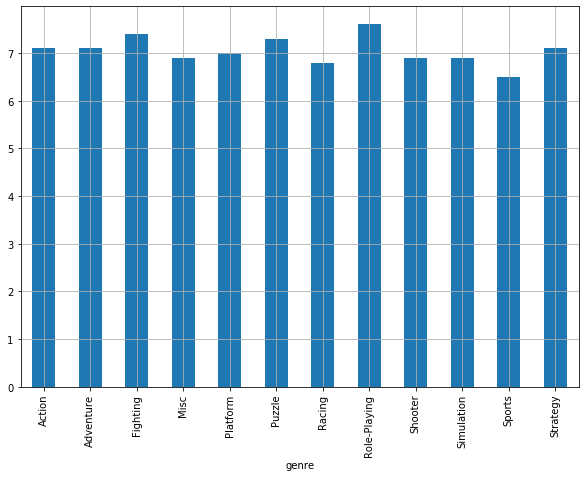

In [88]:
df_striped.groupby('genre').median().user_score.plot(kind='bar', figsize=(10,7), grid=True)

Медианный user score не особо не зависит от жанра, но у ролевых игр он немного больше, чем у остальных

In [89]:
genres_list = df_striped.genre.unique().tolist()

Text(0.5, 0.98, 'Гистограммы распределения оценок пользователей у каждой платформы')

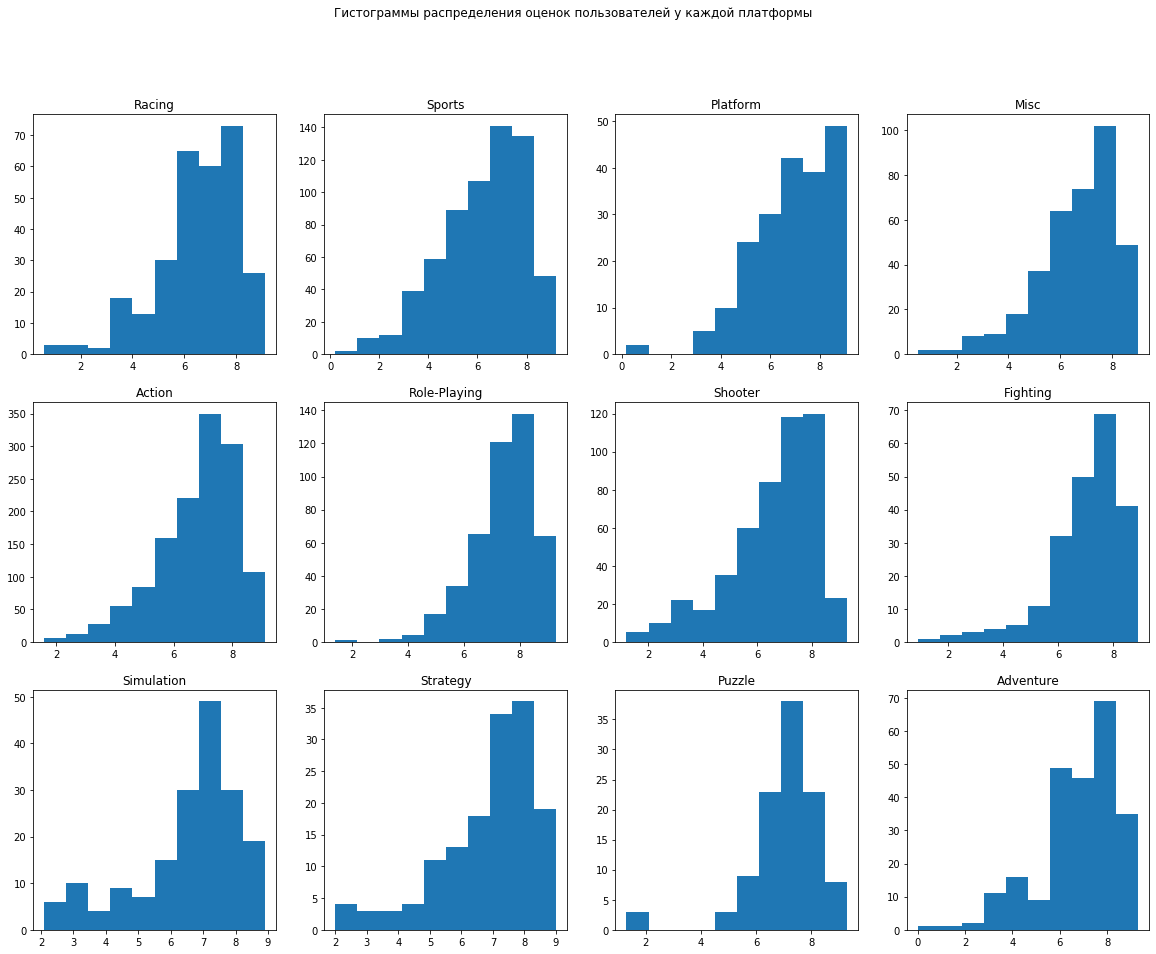

In [90]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20,15))

axes = axes.flatten()

num_of_bins = 10

for genre,ax in zip(genres_list,axes):
    ax.hist(df_striped[df_striped['genre']==genre].user_score, bins=num_of_bins)
    ax.set_title(genre)
fig.suptitle('Гистограммы распределения оценок пользователей у каждой платформы')


### Рейтинг критиков

In [91]:
df_striped.groupby('genre').median().critic_score

genre
Action          70.0000
Adventure       65.6273
Fighting        74.0000
Misc            70.0000
Platform        71.0000
Puzzle          70.0000
Racing          70.0000
Role-Playing    74.0000
Shooter         74.0000
Simulation      66.0000
Sports          72.0000
Strategy        75.0000
Name: critic_score, dtype: float64

In [92]:
df_striped.groupby('genre').std().critic_score

genre
Action          13.380860
Adventure       14.722895
Fighting        13.397573
Misc            13.654674
Platform        14.758304
Puzzle          11.514360
Racing          14.133031
Role-Playing    12.235112
Shooter         14.917894
Simulation      12.040824
Sports          15.845794
Strategy        12.366751
Name: critic_score, dtype: float64

In [93]:
df_striped.groupby('genre').std().critic_score

genre
Action          13.380860
Adventure       14.722895
Fighting        13.397573
Misc            13.654674
Platform        14.758304
Puzzle          11.514360
Racing          14.133031
Role-Playing    12.235112
Shooter         14.917894
Simulation      12.040824
Sports          15.845794
Strategy        12.366751
Name: critic_score, dtype: float64

In [94]:
df_striped.genre.value_counts()

Action          2023
Misc            1018
Sports           973
Adventure        875
Role-Playing     793
Shooter          595
Simulation       473
Racing           412
Fighting         311
Strategy         292
Puzzle           261
Platform         247
Name: genre, dtype: int64

Text(0.5, 0.98, 'Гистограммы распределения оценок критиков у каждой платформы')

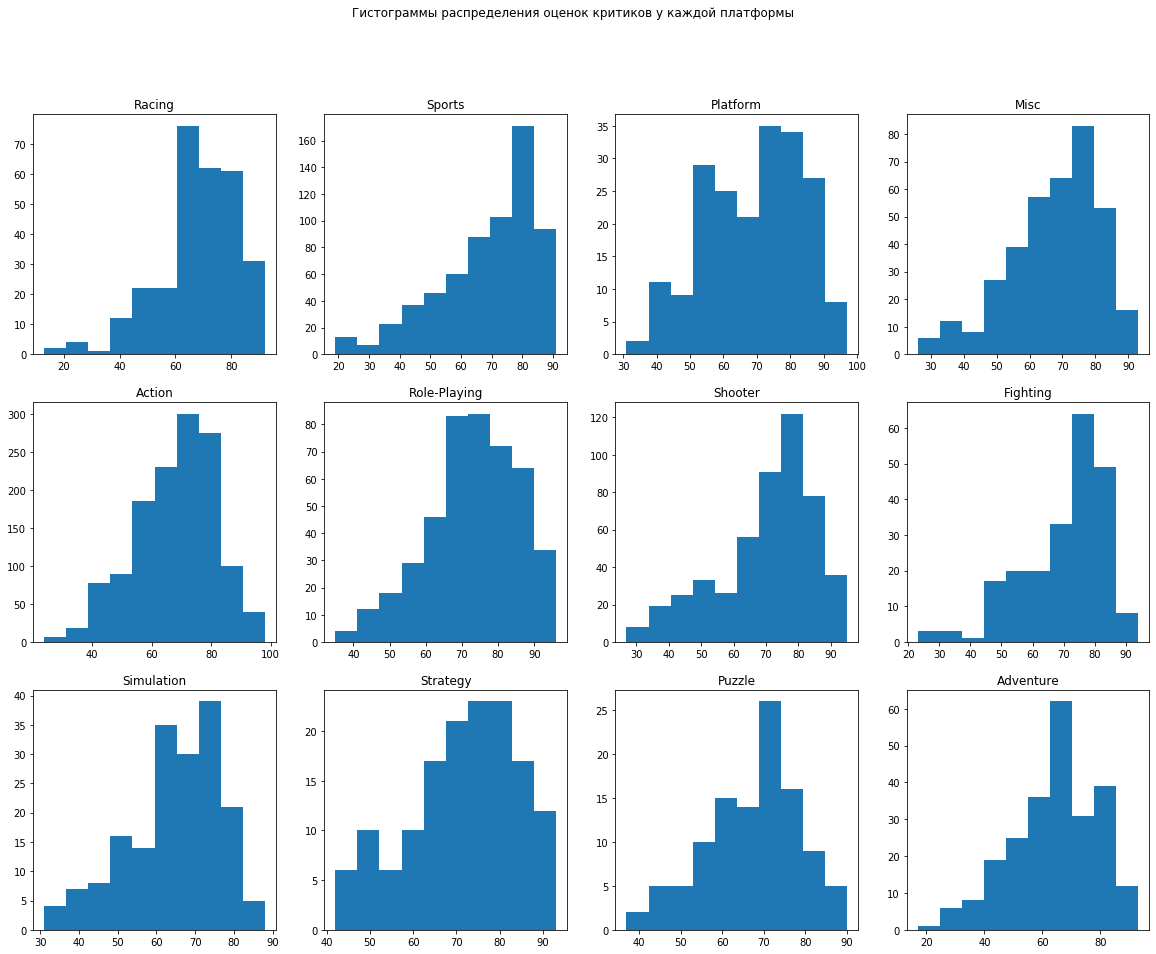

In [95]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20,15))

axes = axes.flatten()

num_of_bins = 10

for genre,ax in zip(genres_list,axes):
    ax.hist(df_striped[df_striped['genre']==genre].critic_score, bins=num_of_bins)
    ax.set_title(genre)
fig.suptitle('Гистограммы распределения оценок критиков у каждой платформы')


**Вывод**
Обратите внимание, что у некоторых жанров можно выявить явно наиболее часто встречающиеся оценки у критиков или у пользователей. Допустим у жанра спорт наиболее вероятная оценка критиков будет чуть больше 80

# Шаг 7. Проверьте гипотезы

## Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

**Нулевая гипотеза:**  средний пользовательский рейтинг платформы Xbox One == средний пользовательский рейтинг платформы PC

**Альтернативная гипотеза:**   средний пользовательский рейтинг платформы Xbox One != средний пользовательский рейтинг платформы PC

In [96]:
alpha = 0.01

a = df_striped.loc[df_striped['platform']=='XOne'].user_score.dropna().values
b = df_striped.loc[df_striped['platform']=='PC'].user_score.dropna().values

if ttest_ind(a,b).pvalue>alpha:
    print('Не можем отклонить нулевую гипотезу')
else:
    print('Отклоняем нулевую гипотезу о равенстве средних')
    

Не можем отклонить нулевую гипотезу


## Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.

**Нулевая гипотеза:** средний пользовательский рейтинг жанра Action == средний пользовательский рейтинг жанра Sports

**Альтернативная гипотеза:**  средний пользовательский рейтинг жанра Action != средний пользовательский рейтинг жанра Sports

In [97]:
# для тоо, чтобы правильно проверить через Т-критерий Стьюдента, надо уточнить аргумент equal_var в функции
# equal_var говорит о равенстве дисперсий 2 выборок
# так что пока проверим равенство их дисперсий

# нулевая гипотеза - дисперсии выборок равны
# альтернативная гипотеза - дисперсии не равны
alpha= 0.05
a = df_striped.loc[df_striped['genre']=='Action'].user_score.dropna().values
b = df_striped.loc[df_striped['genre']=='Sports'].user_score.dropna().values



if levene(a,b).pvalue>alpha:
    print('Не можем отклонить нулевую гипотезу')
else:
    print('Отклоняем нулевую гипотезу о равенстве дисперсий')
   

Отклоняем нулевую гипотезу о равенстве дисперсий


Следовательно надо выставить параметр equal_var функции ttest_ind в значение **False**

In [98]:
alpha = 0.01


a = df_striped.loc[df_striped['genre']=='Action'].user_score.dropna().values
b = df_striped.loc[df_striped['genre']=='Sports'].user_score.dropna().values

if ttest_ind(a,b,equal_var=False).pvalue>alpha:
    print('Не можем отклонить нулевую гипотезу')
else:
    print('Отклоняем нулевую гипотезу о равенстве средних')
    

Отклоняем нулевую гипотезу о равенстве средних


## Пояснение

### Как вы сформулировали нулевую и альтернативную гипотезы;

Нулевая гипотеза по определению должна быть со знаком равенства, а в альтернативную мы уже закладываем смысл, который нам нужен

### Какой критерий применили для проверки гипотез и почему.


Для сравнения статистик двух выборок нужно использовать t-test.

# Шаг 8. Общий вывод

**Датасет на котором проводился анализ:** статистика продаж игр

**Проблемы с которыми я столкнулся:** много пропущенных значений, неподходящие типы столбцов

**Методика обработки пропущенных значений:** 
* находил частичный дубликат записи(отличался допустим платформой) и переносил оттуда информацию в пропущенные значения
* делил данные на когорты по определенному признаку, для каждой когорты находил среднее значение целевого столбца и заполнял им соответственно пропущенные значения

**Инсайты для компании:**

Наиболее перспективной является плафтморма PS4. Она будет еще "жива" ориентировочно до 2022 года.

На платформу PC не распространяется особенность 10-летнего срока жизни всех других платформ. Она существует уже десятки лет.

На коммерческий успех игры больше влияют рейтинги критиков, чем рейтинги игроков

### Выводы:
#### Шаг 4. Исследовательский анализ данных
##### Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
Необязательно смотреть данные за все годы, так как многие платформы уже канули в лету и статистика за прошлые годы не принесет нам никакой пользы
##### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.
- Лидирует по продажам PS4. 
- На всем рынке заметна тенденция снижения
- Растущих платформ на 2016 год нет
- Перспективные платформы:
- - PS4
- - PC
- - XOne
- - WiiU

##### Постройте график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах? Опишите результат.
Разница в основном незначительна. С 1 по 3 квартиль разные платформы демонстрируют похожие продажи. То есть медианные продажи не будут сильно различаться, чего не скажешь о средних. У платформы Wii есть настоящий хит - Wii Sports. Он является самым что ни на есть выбросом в наших данных.

##### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы и соотнесите их с продажами игр на других платформах.
Для большинства платформ заметна положительная корреляция между critic_score/user_score и суммарным количеством продаж

Примечателен тот факт, что для PS2 почти не заметна корреляция судя по графику.

Высокий рейтинг далеко не всегда означает большие продажи, но вот низкий рейтинг почти всегда сулит низкий уровень продаж

##### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?
Наиболее доходным является жанр шутеров. Обратите внимание, что я не сказал "прибыльный". Потому что данный жанр также является одним из самых дорогих в создании.
Жанры особо не выдяляются по признаку высокие и них продажи или низкие
#### Шаг 5. Составьте портрет пользователя каждого региона
**Американский пользователь** предпочитает в первую очередь XBox. Любит играть в шутеры. Не очень любит играть в Action и Ролевые игры. 

**Европейский пользователь** предпочитает в первую очередь Playstation. Любит играть в шутеры. Не любит файтинги, ролевые игры и симуляторы.

**Японский пользователь** предпочитает Nintendo и очень холодно относится к XBox. Любит играть в ролевые игры. Не любит шутеры, спортивные игры и гонки.

#### Шаг 6. Проведите исследование статистических показателей
##### Пользовательский рейтинг
Медианный user score не особо не зависит от жанра, но у ролевых игр он немного больше, чем у остальных.

##### Рейтинг критиков
Наибольшее число жанров с количеством игр от 250 до 500.

Однако в данном распределении есть заметный выброс - Action. Весьма популярный жанр для игроделов

#### Шаг 7. Проверьте гипотезы
Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Средние пользовательские рейтинги жанров Action и Sports разные